In [1]:
import tensorflow as tf

import os
import random
import pandas as pd
import numpy as np

# Classes for Loading Data

In [2]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [3]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines
        
    @classmethod
    def _read_csv(cls, input_file):
        """Reads a comma separated value file."""
        file=pd.read_csv(input_file)
        lines=zip(file.ID,file.TEXT,file.Label)
        return lines

In [4]:
class readmissionProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train.csv")), "train")
    
    def get_dev_examples(self, data_dir):
        return self._create_examples(self._read_csv(os.path.join(data_dir, "val.csv")), "val")
    
    def get_test_examples(self, data_dir):
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test.csv")), "test")
    
    def get_labels(self):
        return ["0", "1"]
    
    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[1]
            label = str(int(line[2])) 
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


In [5]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [6]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [7]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


# Load Model

In [3]:
from transformers import TFBertForSequenceClassification
bert_model='./model/pretraining'
model = TFBertForSequenceClassification.from_pretrained(bert_model, from_pt=True)

model.layers[0].trainable = False
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240
_________________________________________________________________


# Process and Load Data

### Initialize Processor

In [9]:
data_dir = './data'
processor = readmissionProcessor()
label_list = processor.get_labels() 
max_seq_length = 128

### Initialize Tokenizer

In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Create DataSets

In [ ]:
### Training, Val, Test Data
train_examples = processor.get_train_examples(data_dir)
train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer)
train_input_ids = tf.constant([f.input_ids for f in train_features], dtype=tf.int32)
train_input_mask = tf.constant([f.input_mask for f in train_features], dtype=tf.int32)
train_segment_ids = tf.constant([f.segment_ids for f in train_features], dtype=tf.int32)
train_label_ids = tf.one_hot(tf.constant([f.label_id for f in train_features], dtype=tf.int32), 2, dtype=tf.int32)
train_data = tf.data.Dataset.from_tensor_slices(({"input_ids": train_input_ids, "attention_mask": train_input_mask, 
                                                  "token_type_ids": train_segment_ids}, 
                                                 train_label_ids))

val_examples = processor.get_dev_examples(data_dir)
val_features = convert_examples_to_features(val_examples, label_list, max_seq_length, tokenizer)
val_input_ids = tf.constant([f.input_ids for f in val_features], dtype=tf.int32)
val_input_mask = tf.constant([f.input_mask for f in val_features], dtype=tf.int32)
val_segment_ids = tf.constant([f.segment_ids for f in val_features], dtype=tf.int32)
val_label_ids = tf.one_hot(tf.constant([f.label_id for f in val_features], dtype=tf.int32), 2, dtype=tf.int32)
val_data = tf.data.Dataset.from_tensor_slices(({"input_ids": val_input_ids, "attention_mask": val_input_mask, 
                                                  "token_type_ids": val_segment_ids}, 
                                                 val_label_ids))

test_examples = processor.get_test_examples(data_dir)
test_features = convert_examples_to_features(test_examples, label_list, max_seq_length, tokenizer)
test_input_ids = tf.constant([f.input_ids for f in test_features], dtype=tf.int32)
test_input_mask = tf.constant([f.input_mask for f in test_features], dtype=tf.int32)
test_segment_ids = tf.constant([f.segment_ids for f in test_features], dtype=tf.int32)
test_label_ids = tf.one_hot(tf.constant([f.label_id for f in test_features], dtype=tf.int32), 2, dtype=tf.int32)
test_data = tf.data.Dataset.from_tensor_slices(({"input_ids": test_input_ids, "attention_mask": test_input_mask, 
                                                  "token_type_ids": test_segment_ids}, 
                                                 test_label_ids))

### Save Data

In [ ]:
train_dir = os.path.join(data_dir, 'train_dataset')
val_dir = os.path.join(data_dir, 'val_dataset')
test_dir = os.path.join(data_dir, 'test_dataset')

tf.data.experimental.save(train_data, train_dir)
tf.data.experimental.save(val_data, val_dir)
tf.data.experimental.save(test_data, test_dir)

### Load Data

In [11]:
train_dir = os.path.join(data_dir, 'train_dataset')
val_dir = os.path.join(data_dir, 'val_dataset')
test_dir = os.path.join(data_dir, 'test_dataset')

element_spec = ({'input_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None),
                 'token_type_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(2,), dtype=tf.int32, name=None))

train_data = tf.data.experimental.load(train_dir, element_spec)
val_data = tf.data.experimental.load(val_dir, element_spec)
test_data = tf.data.experimental.load(test_dir, element_spec)

# Train Model

In [19]:
# Training Parameters
epochs = 50
batch_size = 16
eval_batch_size = 16

train_data_size = len(train_data)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

#LR scheduler 
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=2e-5, 
                                                             end_learning_rate=0, 
                                                             decay_steps=num_train_steps)
# Optimizer
# optimizer = nlp.optimization.create_optimizer(
#     2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

In [20]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Checkpointing
checkpointing = tf.keras.callbacks.ModelCheckpoint('model/weights/',
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   monitor='val_loss',
                                                   mode='min',
                                                   verbose=1)
# Early Stopping 
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

# Metrics
metrics = ['accuracy',]
#           tf.keras.metrics.AUC(name='auroc'),
#           tf.keras.metrics.AUC(curve='PR', name='auprc')]

# Compile Model
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

In [ ]:
model.fit(train_data.shuffle(20000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE), 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data = val_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE), 
          callbacks=[checkpointing, earlyStop])

In [4]:
model.load_weights('model/weights/')
model.save_pretrained('model/model')

# Evaluate Model

### Initial Evaluation

In [69]:
model_test = tf.keras.models.Sequential()
model_test.add(model)
model_test.add(tf.keras.layers.Lambda(lambda x: x.logits))
model_test.add(tf.keras.layers.Activation('softmax'))
for x in train_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE):
    model_test(x)
    break
model_test.summary()

metrics = ['accuracy',
          tf.keras.metrics.AUC(name='auroc'),
          tf.keras.metrics.AUC(curve='PR', name='auprc')]

# Compile Model
model_test.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

model_test.evaluate(test_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))

array([[  101,  1048,  2615, ...,  2000,  8777,   102],
       [  101,  2000,  3770, ..., 12532, 16778,   102],
       [  101, 12030,  2006, ...,  1010,  2893,   102],
       ...,
       [  101,  1998,  6749, ...,  9626,  4588,   102],
       [  101,  2326,  1024, ...,  2000,  9634,   102],
       [  101,  2371,  2000, ...,  7687,  3671,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}, <tf.Tensor: shape=(16, 2), dtype=int32, numpy=
array([[0, 1],

[0.6539075374603271, 0.639895498752594, 0.6854345798492432, 0.671398937702179]

### Evaluation Functions

In [70]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from inspect import signature
import matplotlib.pyplot as plt

In [71]:
def vote_score(df, score, readmission_mode, output_dir):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score 
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    string = 'auroc_clinicalbert_'+readmission_mode+'.png'
    plt.savefig(os.path.join(output_dir, string))

    return fpr, tpr, df_out

In [72]:
def pr_curve_plot(y, y_score, readmission_mode, output_dir):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall,precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(area))
    plt.show()
    
    string = 'auprc_clinicalbert_'+readmission_mode+'.png'

    plt.savefig(os.path.join(output_dir, string))

In [73]:
def vote_pr_curve(df, score, readmission_mode, output_dir):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score 
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    
    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data =  list(zip(precision, recall, thres)), columns = ['prec','recall','thres'])
    vote_df = pd.DataFrame(data =  list(zip(temp, y)), columns = ['score','label'])
    
    pr_curve_plot(y, temp, readmission_mode, output_dir)
    
    temp = pr_thres[pr_thres.prec > 0.799999].reset_index()
    
    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print('Recall at Precision of 80 is {}', rp80)

    return rp80


### Evaluate on Val and Test Set

In [74]:
model_dir = os.path.join(os.getcwd(), 'model')

### Get Logits
y_logits_val = model_test.predict(val_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))[:,1]
y_logits_test = model_test.predict(test_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))[:,1]

### Load DataFrames
df_val = pd.read_csv(os.path.join(data_dir, "val.csv"))
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

Consider rewriting this model with the Functional API.


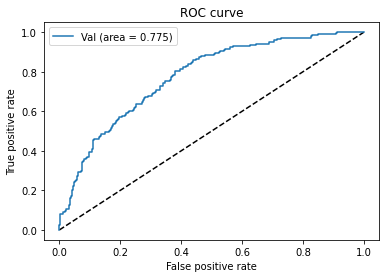

<Figure size 432x288 with 0 Axes>

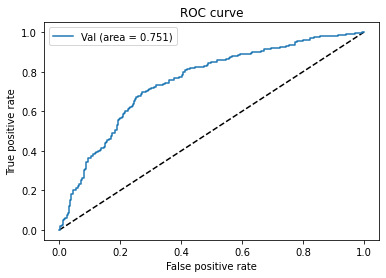

<Figure size 432x288 with 0 Axes>

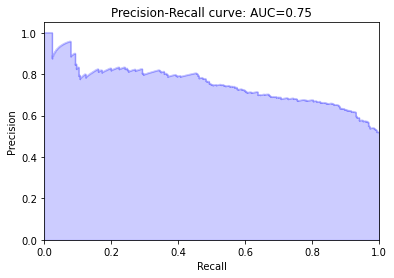

Recall at Precision of 80 is {} 0.4586206896551724


<Figure size 432x288 with 0 Axes>

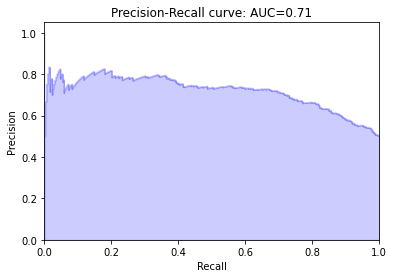

Recall at Precision of 80 is {} 0.20209059233449478


<Figure size 432x288 with 0 Axes>

In [75]:
### Run Evaluation
fpr_test, tpr_test, df_out_test = vote_score(df_test, y_logits_test, 'test', model_dir)
fpr_val, tpr_val, df_out_val = vote_score(df_val, y_logits_val, 'val', model_dir)

rp80_test = vote_pr_curve(df_test, y_logits_test, 'test', model_dir)
rp80_val = vote_pr_curve(df_val, y_logits_val, 'val', model_dir)

### Save DF
string_test = 'logits_clinicalbert_'+'test'+'_readmissions.csv'
string_val = 'logits_clinicalbert_'+'val'+'_readmissions.csv'
df_out_test.to_csv(os.path.join(model_dir, string_test))
df_out_val.to_csv(os.path.join(model_dir, string_val))